# Projeto de Modelagem de Aprovação de Crédito: Um Case

## Contextualização

No início de 2023, o departamento de crédito do Banco Nacional de Finanças (BNF) enfrentava um desafio significativo. Com uma taxa de inadimplência crescente e um processo manual de análise que levava, em média, 3 dias úteis para aprovar ou rejeitar solicitações de crédito, era evidente que uma transformação digital se fazia necessária.

Durante uma reunião trimestral de resultados, Maria Silva, Diretora de Crédito do BNF, apresentou números preocupantes:

- Tempo médio de análise: 3 dias úteis
- Taxa de inadimplência: 12% (2% acima do mercado)
- Taxa de abandono de solicitações: 22% (clientes desistiam durante o processo)
- Alta correlação entre demora para aprovação e abandono de solicitações
- Custo operacional da análise manual: R$2,2 milhões/ano

"Precisamos modernizar nosso processo de análise de crédito. Acredito que a ciência de dados possa nos ajudar a tomar decisões mais precisas e ágeis", afirmou Maria durante a apresentação.

Foi assim que, na semana seguinte, nosso time de Data Science recebeu um e-mail com o assunto: "URGENTE: Projeto Estratégico - Modelo de Aprovação de Crédito Automatizado".

O desafio estava lançado: desenvolver um modelo preditivo capaz de aprovar ou rejeitar solicitações de crédito de forma automática, reduzindo o tempo de análise para segundos, diminuindo a taxa de inadimplência/abandono e, consequentemente, aumentando a rentabilidade da carteira de crédito do banco.

Nossa jornada começou com a coleta e análise de dados históricos de aprovações e rejeições de crédito do último ano. Este notebook documenta o processo de desenvolvimento, avaliação e implementação do modelo que transformaria o departamento de crédito do BNF.

## Objetivos do Projeto

1. Reduzir o tempo de análise de crédito de 3 dias para menos de 1 minuto
2. Diminuir a taxa de inadimplência em pelo menos 3 pontos percentuais
3. Aumentar a aprovação de bons pagadores em 15%
4. Criar um modelo explicável/interpretável que possa ser auditado pelos reguladores bancários

Vamos iniciar esta jornada explorando os dados disponíveis e entendendo os padrões que podem nos ajudar a prever com precisão quais clientes têm maior probabilidade de honrar seus compromissos financeiros.


# 1. Tratando e Explorando Dados

## 1.1 Importando Bibliotecas

In [ ]:
! pip install pandas
! pip install seaborn
! pip install scipy
! pip install scikit-learn
! pip install imblearn


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


   ---------------------------------------- 0.0/11.1 MB ? eta -:--:--
   -------- ------------------------------- 2.4/11.1 MB 11.4 MB/s eta 0:00:01
   ----------------- ---------------------- 4.7/11.1 MB 11.5 MB/s eta 0:00:01
   ------------------------- -------------- 7.1/11.1 MB 11.5 MB/s eta 0:00:01
   ---------------------------------- ----- 9.4/11.1 MB 11.6 MB/s eta 0:00:01
   ---------------------------------------  11.0/11.1 MB 11.6 MB/s eta 0:00:01
   ---------------------------------------- 11.1/11.1 MB 10.2 MB/s eta 0:00:00



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

## 1.2 Lendo dados e traduzindo para melhor compreensão

In [3]:
df = pd.read_csv("Application_data.csv")

Vamos traduzir os dados, começando pelas colunas

In [4]:
# Mudando nomes das colunas
# Dicionário de tradução das colunas
traducao_colunas = {
    'Applicant_ID': 'ID_Solicitante',
    'Applicant_Gender': 'Genero_Solicitante',
    'Owned_Car': 'Possui_Carro',
    'Owned_Realty': 'Possui_Imovel',
    'Total_Children': 'Total_Filhos',
    'Total_Income': 'Renda_Total',
    'Income_Type': 'Tipo_Renda',
    'Education_Type': 'Nivel_Educacao',
    'Family_Status': 'Estado_Civil',
    'Housing_Type': 'Tipo_Moradia',
    'Owned_Mobile_Phone': 'Possui_Celular',
    'Owned_Work_Phone': 'Possui_Tel_Comercial',
    'Owned_Phone': 'Possui_Tel_Fixo',
    'Owned_Email': 'Possui_Email',
    'Job_Title': 'Cargo',
    'Total_Family_Members': 'Total_Membros_Familia',
    'Applicant_Age': 'Idade_Solicitante',
    'Years_of_Working': 'Anos_Trabalho',
    'Total_Bad_Debt': 'Total_Dividas_Ruins',
    'Total_Good_Debt': 'Total_Dividas_Boas',
    'Status': 'Status'
}

# Renomear as colunas do DataFrame
df = df.rename(columns=traducao_colunas)

# Verificar as novas colunas
print("Novas colunas traduzidas:")
print(df.columns)

Novas colunas traduzidas:
Index(['ID_Solicitante', 'Genero_Solicitante', 'Possui_Carro', 'Possui_Imovel',
       'Total_Filhos', 'Renda_Total', 'Tipo_Renda', 'Nivel_Educacao',
       'Estado_Civil', 'Tipo_Moradia', 'Possui_Celular',
       'Possui_Tel_Comercial', 'Possui_Tel_Fixo', 'Possui_Email', 'Cargo',
       'Total_Membros_Familia', 'Idade_Solicitante', 'Anos_Trabalho',
       'Total_Dividas_Ruins', 'Total_Dividas_Boas', 'Status'],
      dtype='object')


In [5]:
# Nesse caso, vamos remover os espaços em branco das variáveis categóricas
# para que não haja confusão entre valores idênticos, mas com espaços diferentes
# Exemplo: 'Masculino' e 'Masculino ' são tratados como valores diferentes
# Remover espaços nas bordas das variáveis categóricas
categorical_columns = ['Genero_Solicitante', 'Tipo_Renda', 'Nivel_Educacao', 
                      'Estado_Civil', 'Tipo_Moradia', 'Cargo']

# Aplicar strip() em todas as colunas categóricas
for col in categorical_columns:
    df[col] = df[col].str.strip()

# Verificar o resultado para uma coluna
print("Valores únicos após remoção dos espaços:")
for col in categorical_columns:
    print(f"\n{col}:")
    print(df[col].unique())

Valores únicos após remoção dos espaços:

Genero_Solicitante:
['M' 'F']

Tipo_Renda:
['Working' 'Commercial associate' 'State servant' 'Student' 'Pensioner']

Nivel_Educacao:
['Secondary / secondary special' 'Higher education' 'Incomplete higher'
 'Lower secondary' 'Academic degree']

Estado_Civil:
['Married' 'Single / not married' 'Civil marriage' 'Separated' 'Widow']

Tipo_Moradia:
['House / apartment' 'Rented apartment' 'Municipal apartment'
 'With parents' 'Co-op apartment' 'Office apartment']

Cargo:
['Security staff' 'Sales staff' 'Accountants' 'Laborers' 'Managers'
 'Drivers' 'Core staff' 'High skill tech staff' 'Cleaning staff'
 'Private service staff' 'Cooking staff' 'Low-skill Laborers'
 'Medicine staff' 'Secretaries' 'Waiters/barmen staff' 'HR staff'
 'Realty agents' 'IT staff']


In [6]:
df['Tipo_Renda'].unique()

array(['Working', 'Commercial associate', 'State servant', 'Student',
       'Pensioner'], dtype=object)

In [7]:
# Vamos transformar os valores das colunas para português
# Dicionário de traduções para variáveis categóricas
traducoes = {
    # Gênero
    'M': 'M',
    'F': 'F',
    
    # Tipo de Renda
    'Working': 'Trabalhador CLT',
    'Commercial associate': 'Associado Comercial',
    'State servant': 'Servidor Público',
    'Student': 'Estudante',
    'Pensioner': 'Aposentado',
    
    # Educação
    'Secondary / secondary special': 'Ensino Médio / Técnico',
    'Higher education': 'Ensino Superior',
    'Incomplete higher': 'Superior Incompleto',
    'Lower secondary': 'Ensino Fundamental',
    'Academic degree': 'Pós-graduação',
    
    # Estado Civil
    'Married': 'Casado',
    'Single / not married': 'Solteiro',
    'Civil marriage': 'União Estável',
    'Separated': 'Separado',
    'Widow': 'Viúvo',
    
    # Tipo de Moradia
    'House / apartment': 'Casa/Apartamento',
    'Rented apartment': 'Apartamento Alugado',
    'Municipal apartment': 'Apartamento Municipal',
    'With parents': 'Com os Pais',
    'Co-op apartment': 'Apartamento Cooperativa',
    'Office apartment': 'Apartamento Funcional',
    
    # Cargos
    'Security staff': 'Equipe de Segurança',
    'Sales staff': 'Equipe de Vendas',
    'Accountants': 'Contadores',
    'Laborers': 'Trabalhadores Braçais',
    'Managers': 'Gerentes',
    'Drivers': 'Motoristas',
    'Core staff': 'Equipe Principal',
    'High skill tech staff': 'Equipe Técnica Especializada',
    'Cleaning staff': 'Equipe de Limpeza',
    'Private service staff': 'Equipe de Serviço Privado',
    'Cooking staff': 'Equipe de Cozinha',
    'Low-skill Laborers': 'Trabalhadores Não Especializados',
    'Medicine staff': 'Equipe Médica',
    'Secretaries': 'Secretários',
    'Waiters/barmen staff': 'Garçons/Bartenders',
    'HR staff': 'Equipe de RH',
    'Realty agents': 'Corretores de Imóveis',
    'IT staff': 'Equipe de TI'
}

# Aplicar traduções
colunas_categoricas = ['Tipo_Renda', 'Nivel_Educacao', 'Estado_Civil', 'Tipo_Moradia', 'Cargo']

for coluna in colunas_categoricas:
    df[coluna] = df[coluna].map(traducoes)

# Verificar resultado
print("Valores únicos após tradução:")
for coluna in colunas_categoricas:
    print(f"\n{coluna}:")
    print(df[coluna].unique())

Valores únicos após tradução:

Tipo_Renda:
['Trabalhador CLT' 'Associado Comercial' 'Servidor Público' 'Estudante'
 'Aposentado']

Nivel_Educacao:
['Ensino Médio / Técnico' 'Ensino Superior' 'Superior Incompleto'
 'Ensino Fundamental' 'Pós-graduação']

Estado_Civil:
['Casado' 'Solteiro' 'União Estável' 'Separado' 'Viúvo']

Tipo_Moradia:
['Casa/Apartamento' 'Apartamento Alugado' 'Apartamento Municipal'
 'Com os Pais' 'Apartamento Cooperativa' 'Apartamento Funcional']

Cargo:
['Equipe de Segurança' 'Equipe de Vendas' 'Contadores'
 'Trabalhadores Braçais' 'Gerentes' 'Motoristas' 'Equipe Principal'
 'Equipe Técnica Especializada' 'Equipe de Limpeza'
 'Equipe de Serviço Privado' 'Equipe de Cozinha'
 'Trabalhadores Não Especializados' 'Equipe Médica' 'Secretários'
 'Garçons/Bartenders' 'Equipe de RH' 'Corretores de Imóveis'
 'Equipe de TI']


## 1.3 Obtendo informações iniciais e levantando requisitos de tratamento de dados

Vamos observar quais dos seguintes tratamentos são necessários:

1. Duplicatas
   - Identificação e remoção de registros duplicados
   - Análise de duplicidade em campos chave

2. Dados nulos
   - Verificação de valores ausentes
   - Estratégias de tratamento (imputação ou remoção)

3. Outliers
   - Detecção de valores atípicos
   - Análise de impacto no modelo
   - Definição de estratégia de tratamento

4. Tipagem correta dos dados
   - Verificação dos tipos de dados
   - Conversão para tipos adequados
   - Consistência das categorias

### 1.3.1 Duplicatas

In [8]:
# Identificando a presença de duplicatas
df.duplicated().sum()

np.int64(0)

### 1.3.2 Dados Nulos

In [9]:
# Observando presença de valores nulos
df.isnull().sum()

ID_Solicitante           0
Genero_Solicitante       0
Possui_Carro             0
Possui_Imovel            0
Total_Filhos             0
Renda_Total              0
Tipo_Renda               0
Nivel_Educacao           0
Estado_Civil             0
Tipo_Moradia             0
Possui_Celular           0
Possui_Tel_Comercial     0
Possui_Tel_Fixo          0
Possui_Email             0
Cargo                    0
Total_Membros_Familia    0
Idade_Solicitante        0
Anos_Trabalho            0
Total_Dividas_Ruins      0
Total_Dividas_Boas       0
Status                   0
dtype: int64

### 1.3.3 Outliers

In [10]:
df.columns

Index(['ID_Solicitante', 'Genero_Solicitante', 'Possui_Carro', 'Possui_Imovel',
       'Total_Filhos', 'Renda_Total', 'Tipo_Renda', 'Nivel_Educacao',
       'Estado_Civil', 'Tipo_Moradia', 'Possui_Celular',
       'Possui_Tel_Comercial', 'Possui_Tel_Fixo', 'Possui_Email', 'Cargo',
       'Total_Membros_Familia', 'Idade_Solicitante', 'Anos_Trabalho',
       'Total_Dividas_Ruins', 'Total_Dividas_Boas', 'Status'],
      dtype='object')

In [11]:
# Listando as variáveis numéricas não binárias
# Criar DataFrame apenas com colunas numéricas excluindo as que contém "Possui"
colunas_numericas = df.select_dtypes(include=['int64', 'float64']).columns
colunas_sem_possui = [col for col in colunas_numericas 
                     if 'Possui' not in col 
                     and 'Status' not in col 
                     and 'ID_Solicitante' not in col]

df_numericas = df[colunas_sem_possui]

# Visualizar as colunas selecionadas

df_numericas.describe()


,Total_Filhos,Renda_Total,Total_Membros_Familia,Idade_Solicitante,Anos_Trabalho,Total_Dividas_Ruins,Total_Dividas_Boas
count,25128.000000,2.512800e+04,25128.000000,25128.000000,25128.000000,25128.000000,25128.000000
mean,0.509472,1.948365e+05,2.291309,40.995503,7.690903,0.333095,21.057545
std,0.762937,1.045211e+05,0.928871,9.552832,6.415007,1.569448,14.735347
min,0.000000,2.700000e+04,1.000000,21.000000,1.000000,0.000000,1.000000
25%,0.000000,1.350000e+05,2.000000,33.000000,3.000000,0.000000,9.000000
50%,0.000000,1.800000e+05,2.000000,40.000000,6.000000,0.000000,18.000000
75%,1.000000,2.250000e+05,3.000000,48.000000,10.000000,0.000000,31.000000
max,5.000000,1.575000e+06,7.000000,68.000000,44.000000,49.000000,61.000000


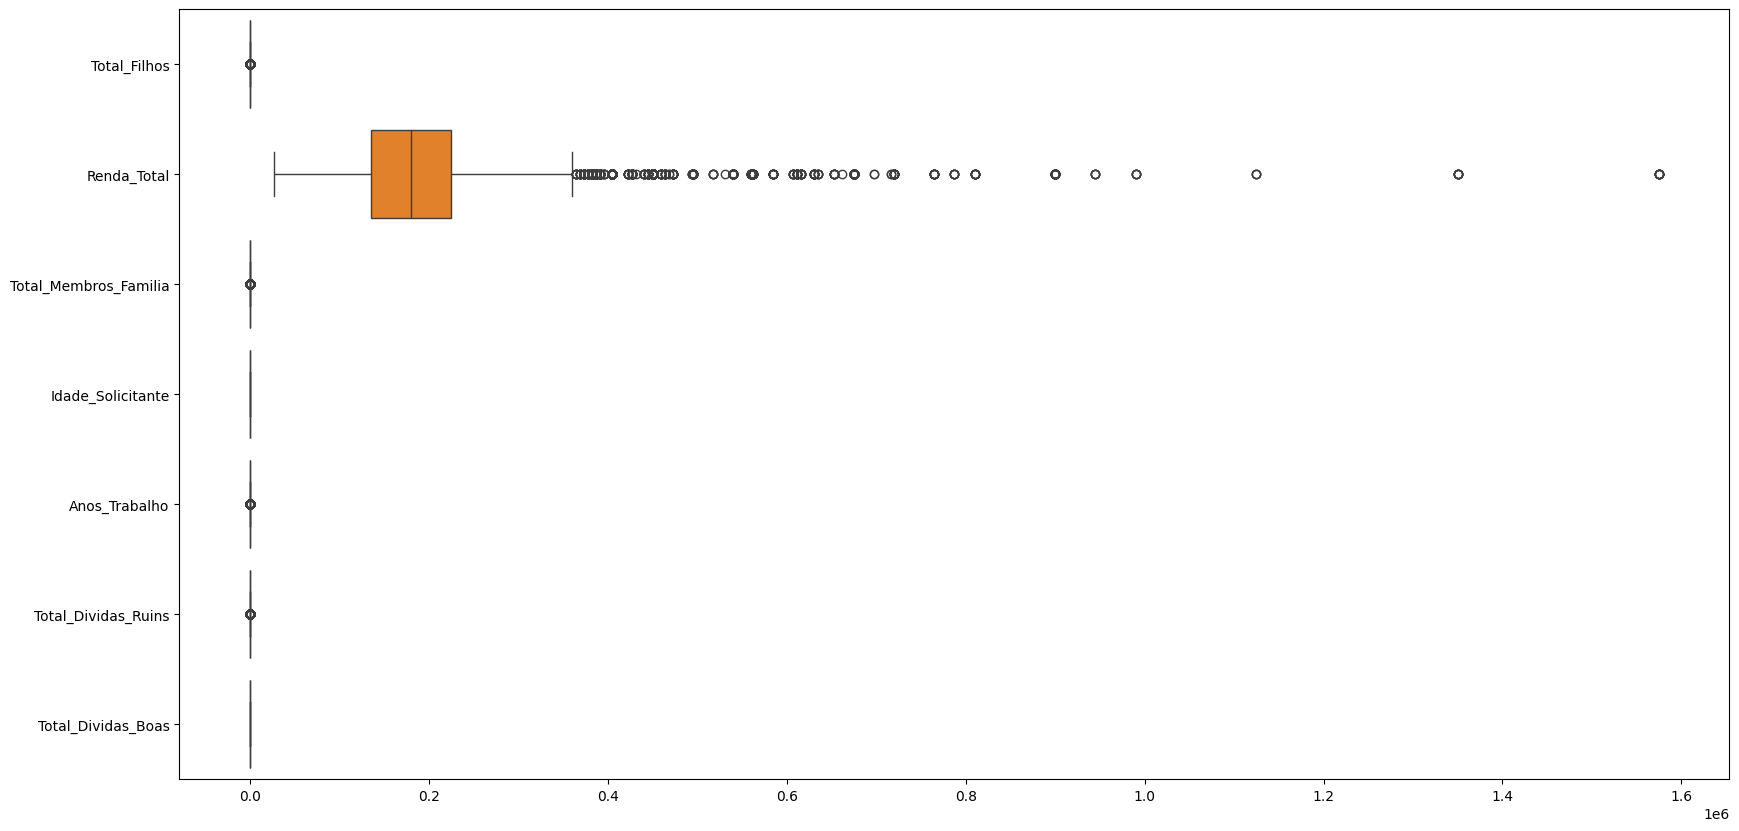

In [12]:
# plotando todas as variaeis em boxplot
plt.figure(figsize=(20,10))
sns.boxplot(data=df_numericas, orient='h')
plt.show()

Dada a discrepância entre a variável de renda e as outras, vamos plotar separadamente renda e as outras:

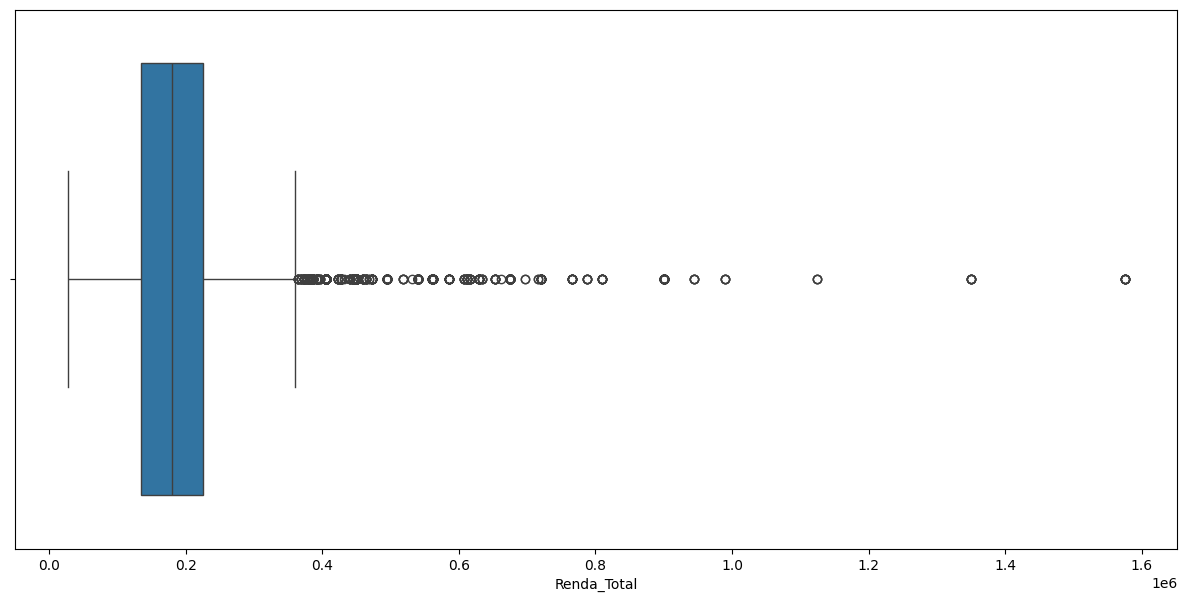

In [13]:
# Plotando renda
plt.figure(figsize=(15,7))
sns.boxplot(data=df_numericas['Renda_Total'], orient='h')
plt.show()

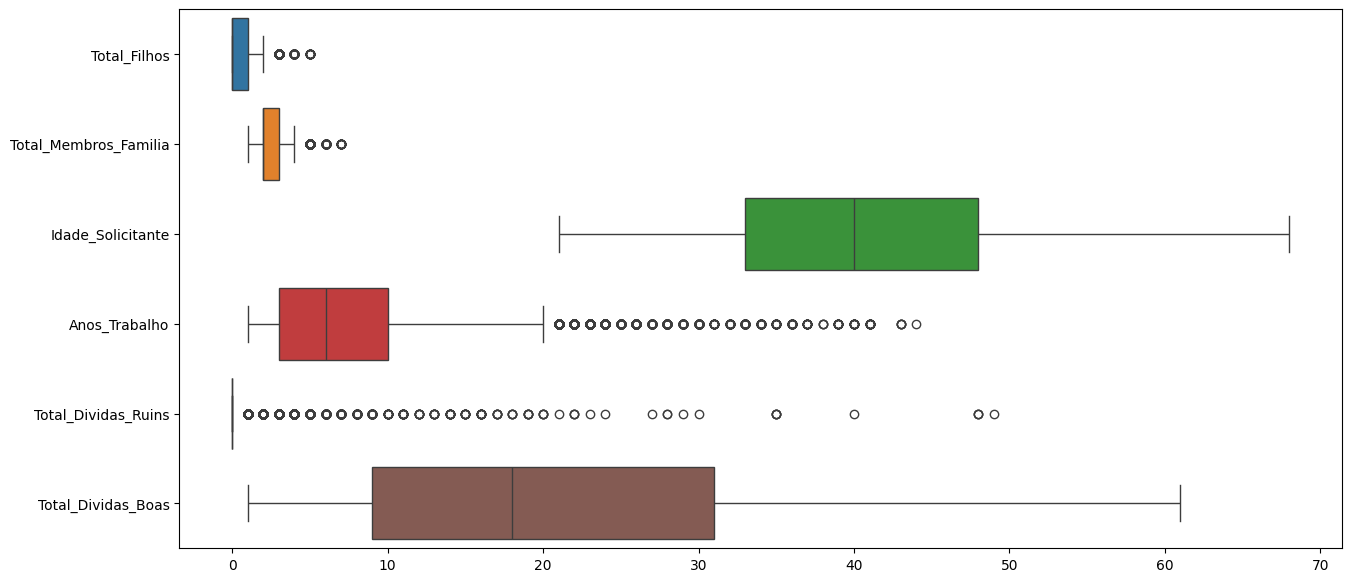

In [14]:
# Plotando as outras variáveis
plt.figure(figsize=(15,7))
sns.boxplot(data=df_numericas.drop('Renda_Total', axis=1), orient='h')
plt.show()

Identificamos uma assimetria significativa na distribuição dos dados de renda, total de dívidas ruins e anos de trabalho o que representa nossa primeira potencial necessidade de tratamento de dados. 

Como o modelo de machine learning ainda não foi definido, não podemos afirmar com certeza se será necessário normalizar estas variáveis. Os modelos paramétricos assumem que os dados seguem uma distribuição normal, enquanto outros, como Random Forest e XGBoost (não paramétricos), não fazem essa exigência.

**Observação importante:** 
- Registrar esta característica dos dados para posterior avaliação
- Considerar possíveis transformações (log, Box-Cox, etc.) caso o modelo escolhido exija normalidade

### 1.3.4 Tipagem dos dados - *Encoding* de Categorias

In [15]:
# Agora vamos olhar para as variáveis categóricas
df_categoricas = df.select_dtypes(include=['object'])
df_categoricas.head()

,Genero_Solicitante,Tipo_Renda,Nivel_Educacao,Estado_Civil,Tipo_Moradia,Cargo
0,M,Trabalhador CLT,Ensino Médio / Técnico,Casado,Casa/Apartamento,Equipe de Segurança
1,F,Associado Comercial,Ensino Médio / Técnico,Solteiro,Casa/Apartamento,Equipe de Vendas
2,F,Associado Comercial,Ensino Médio / Técnico,Solteiro,Casa/Apartamento,Equipe de Vendas
3,F,Associado Comercial,Ensino Médio / Técnico,Solteiro,Casa/Apartamento,Equipe de Vendas
4,F,Associado Comercial,Ensino Médio / Técnico,Solteiro,Casa/Apartamento,Equipe de Vendas


In [16]:
# Observando a quantidade de valores únicos
df_categoricas.nunique()

Genero_Solicitante     2
Tipo_Renda             5
Nivel_Educacao         5
Estado_Civil           5
Tipo_Moradia           6
Cargo                 18
dtype: int64

Para a variável binária (Genero_Solicitante), vamos realizar uma conversão apenas para 0 e 1. Porém, vamos observar se uma transformação como a One-Hot Encoding seria cabível para todas as outras variáveis categóricas. Para isso, podemos determinar quais variáveis são ordinais e quais são nominais:

In [17]:
# Realizando One-Hot Encoding para variável Genero_Solicitante
df = pd.get_dummies(df, columns=['Genero_Solicitante'], drop_first=True)

In [18]:
# Realizando One-Hot Encoding para variável Estado_Civil
df = pd.get_dummies(df, columns=['Estado_Civil'], drop_first=True)

In [19]:
# Observando os valores únicos de todas as variáveis categóricas (exceto Cargo, que possui muitos valores únicos)
unique_values = {col: df_categoricas[col].unique() for col in df_categoricas.columns if (col != 'Cargo' and col != 'Genero_Solicitante')}
unique_values_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in unique_values.items()]))
unique_values_df

,Tipo_Renda,Nivel_Educacao,Estado_Civil,Tipo_Moradia
0,Trabalhador CLT,Ensino Médio / Técnico,Casado,Casa/Apartamento
1,Associado Comercial,Ensino Superior,Solteiro,Apartamento Alugado
2,Servidor Público,Superior Incompleto,União Estável,Apartamento Municipal
3,Estudante,Ensino Fundamental,Separado,Com os Pais
4,Aposentado,Pós-graduação,Viúvo,Apartamento Cooperativa
5,NaN,NaN,NaN,Apartamento Funcional


In [20]:
# Observando os valores únicos de Cargo
unique_values = {col: df_categoricas[col].unique() for col in df_categoricas.columns if col == 'Cargo'}
unique_values_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in unique_values.items()]))
unique_values_df

,Cargo
0,Equipe de Segurança
1,Equipe de Vendas
2,Contadores
3,Trabalhadores Braçais
4,Gerentes
5,Motoristas
6,Equipe Principal
7,Equipe Técnica Especializada
8,Equipe de Limpeza
9,Equipe de Serviço Privado


Podemos afirmar seguramente que as variáveis como gênero e estado civil são nominais.
A princípio, poderíamos afirmar que o tipo de moradia também é nominal, porém, ao observarmos os dados, concluímos que existe uma hierarquia entre os valores únicos, dado que viver com os pais supõe uma pior condição financeira do que ter o próprio apartamento. Mas, ainda não sabemos os detalhes dessa hierarquia, e algumas confusões podem ocorrer. Então, consultei o time de governança de dados e eles me entregaram um dicionário que explica os diferentes valores únicos dessas variáveis categóricas, vamos observá-la para adquirirmos mais informações dos dados, e assim realizarmos uma coerente transformação dessas variáveis ordinais:

#### Dicionário de Dados - Variáveis Categóricas Ordinais


**Tipo_Renda**
Fonte principal de renda do solicitante
- **Trabalhador CLT**: Empregado com carteira assinada
- **Associado Comercial**: Profissional associado a atividades comerciais
- **Servidor Público**: Funcionário público
- **Estudante**: Estudante sem renda ou com renda parcial
- **Aposentado**: Pessoa que recebe aposentadoria

**Nivel_Educacao**
Nível mais alto de educação alcançado
- **Ensino Médio / Técnico**: Completou ensino médio ou curso técnico
- **Ensino Superior**: Possui graduação completa
- **Superior Incompleto**: Iniciou mas não concluiu graduação
- **Ensino Fundamental**: Completou apenas o ensino fundamental
- **Pós-graduação**: Possui especialização, mestrado ou doutorado

**Tipo_Moradia**
Tipo de residência atual
- **Casa/Apartamento**: Imóvel próprio (casa ou apartamento, indica maior renda)
- **Apartamento Alugado**: Mora de aluguel
- **Apartamento Municipal**: Moradia fornecida pelo município
- **Com os Pais**: Reside na casa dos pais
- **Apartamento Cooperativa**: Imóvel em cooperativa habitacional
- **Apartamento Funcional**: Moradia fornecida pelo empregador

In [21]:
# A partir desse dicionário, vamos usar o label enconding para transformar essas variáveis categóricas em numéricas
# Dicionário de tradução para label encoding
# Dicionários para Label Encoding baseados na hierarquia lógica das categorias

# Tipo de Renda (baseado na estabilidade/garantia de renda)
tipo_renda_map = {
    'Servidor Público': 5,    # Maior estabilidade
    'Trabalhador CLT': 4,     # Boa estabilidade
    'Associado Comercial': 3, # Estabilidade média
    'Aposentado': 2,          # Renda estável mas limitada
    'Estudante': 1            # Menor estabilidade financeira
}

# Nível de Educação (baseado no nível acadêmico)
nivel_educacao_map = {
    'Pós-graduação': 5,           # Maior nível
    'Ensino Superior': 4,         # Graduação completa
    'Superior Incompleto': 3,     # Alguma educação superior
    'Ensino Médio / Técnico': 2,  # Educação secundária
    'Ensino Fundamental': 1       # Educação básica
}

# Tipo de Moradia (baseado na independência/estabilidade habitacional)
tipo_moradia_map = {
    'Casa/Apartamento': 6,         # Próprio - maior estabilidade
    'Apartamento Cooperativa': 5,  # Propriedade compartilhada
    'Apartamento Funcional': 4,    # Ligado ao emprego
    'Apartamento Alugado': 3,      # Independente mas com custo mensal
    'Apartamento Municipal': 2,    # Dependente de programa social
    'Com os Pais': 1               # Dependente da família
}

# Cargos baseado no nível de especialização/responsabilidade
cargo_map = {
    'Gerentes': 18,                        # Alta gestão
    'Equipe de TI': 17,                    # Alta especialização técnica
    'Equipe Médica': 16,                   # Alta especialização
    'Equipe Técnica Especializada': 15,    # Especialização técnica
    'Contadores': 14,                      # Especialização financeira
    'Equipe de RH': 13,                    # Especialização em gestão
    'Equipe Principal': 12,                # Core business
    'Corretores de Imóveis': 11,           # Vendas especializadas
    'Equipe de Vendas': 10,                # Vendas gerais
    'Secretários': 9,                      # Administrativo
    'Equipe de Segurança': 8,              # Serviço especializado
    'Equipe de Serviço Privado': 7,        # Serviço qualificado
    'Motoristas': 6,                       # Serviço técnico
    'Equipe de Cozinha': 5,                # Serviço específico
    'Garçons/Bartenders': 4,               # Serviço de atendimento
    'Equipe de Limpeza': 3,                # Serviço básico
    'Trabalhadores Braçais': 2,            # Trabalho manual
    'Trabalhadores Não Especializados': 1  # Sem especialização
}


# Aplicar o Label Encoding
df['Tipo_Renda_Encoded'] = df['Tipo_Renda'].map(tipo_renda_map)
df['Nivel_Educacao_Encoded'] = df['Nivel_Educacao'].map(nivel_educacao_map)
df['Tipo_Moradia_Encoded'] = df['Tipo_Moradia'].map(tipo_moradia_map)
df['Cargo_Encoded'] = df['Cargo'].map(cargo_map)

In [22]:
# Como não será mais necessário as variáveis categóricas sem encoding, vamos removê-las
df = df.drop(columns=['Tipo_Renda', 'Nivel_Educacao', 'Tipo_Moradia', 'Cargo'])

Agora, a única variável categórica restante para tratamento é a de ID: como ela não possui informação intrínseca e útil para o futuro modelo, vamos remover essa coluna

In [23]:
# Dropando coluna de ID
df = df.drop(columns='ID_Solicitante')


### 1.3.5 Tipagem dos dados - Transformando tudo em Variáveis numéricas

In [24]:
df.dtypes

Possui_Carro                  int64
Possui_Imovel                 int64
Total_Filhos                  int64
Renda_Total                   int64
Possui_Celular                int64
Possui_Tel_Comercial          int64
Possui_Tel_Fixo               int64
Possui_Email                  int64
Total_Membros_Familia         int64
Idade_Solicitante             int64
Anos_Trabalho                 int64
Total_Dividas_Ruins           int64
Total_Dividas_Boas            int64
Status                        int64
Genero_Solicitante_M           bool
Estado_Civil_Separado          bool
Estado_Civil_Solteiro          bool
Estado_Civil_União Estável     bool
Estado_Civil_Viúvo             bool
Tipo_Renda_Encoded            int64
Nivel_Educacao_Encoded        int64
Tipo_Moradia_Encoded          int64
Cargo_Encoded                 int64
dtype: object

In [25]:
# Convertendo tudo para int64
df = df.astype('int64')
df.dtypes

Possui_Carro                  int64
Possui_Imovel                 int64
Total_Filhos                  int64
Renda_Total                   int64
Possui_Celular                int64
Possui_Tel_Comercial          int64
Possui_Tel_Fixo               int64
Possui_Email                  int64
Total_Membros_Familia         int64
Idade_Solicitante             int64
Anos_Trabalho                 int64
Total_Dividas_Ruins           int64
Total_Dividas_Boas            int64
Status                        int64
Genero_Solicitante_M          int64
Estado_Civil_Separado         int64
Estado_Civil_Solteiro         int64
Estado_Civil_União Estável    int64
Estado_Civil_Viúvo            int64
Tipo_Renda_Encoded            int64
Nivel_Educacao_Encoded        int64
Tipo_Moradia_Encoded          int64
Cargo_Encoded                 int64
dtype: object

# 2. Seleção de Variáveis

In [ ]:
# Criando uma árvore para determinar quais variáveis são mais importantes


# Separar as variáveis independentes da variável dependente
X = df.drop(columns='Status')
y = df['Status']

# Instanciar o modelo
rf = RandomForestClassifier()

# Treinar o modelo
rf.fit(X, y)

# Extrair a importância das features
importances = rf.feature_importances_   # Quanto maior o valor, mais importante a variável


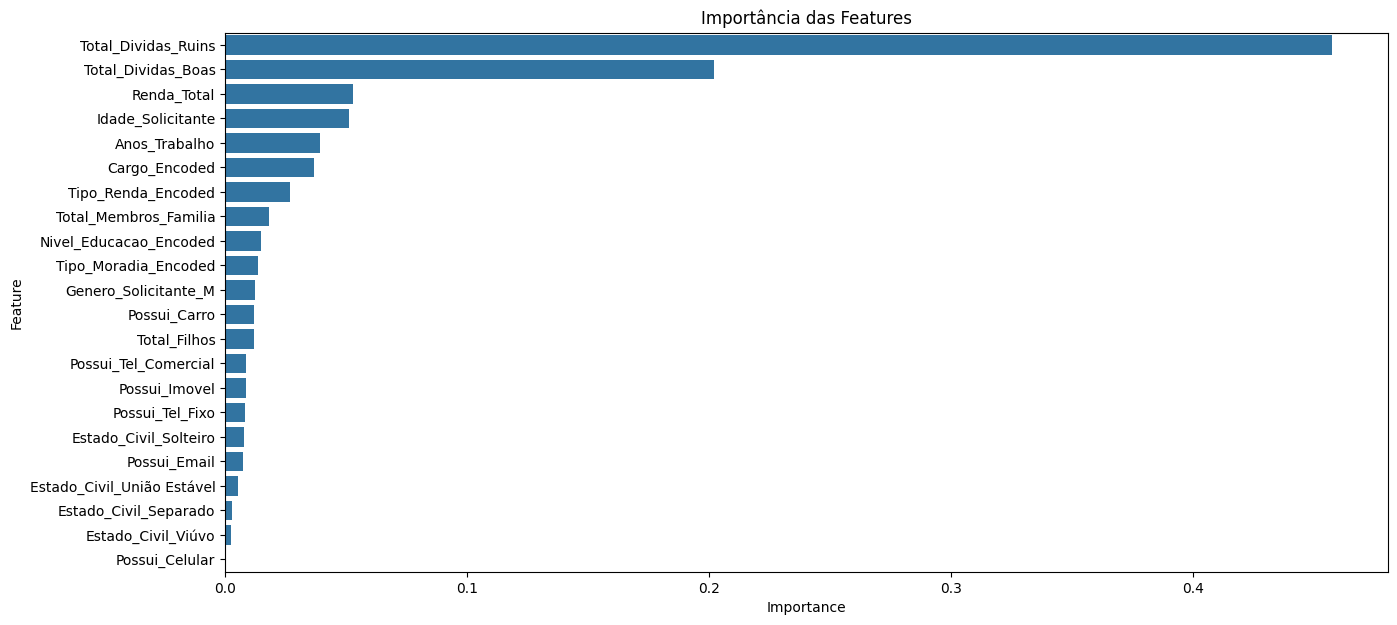

In [28]:
# Plotando a importância das features

# Criar um DataFrame com as importâncias
importances_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
})

# Ordenar o DataFrame
importances_df = importances_df.sort_values(by='Importance', ascending=False)

# Plotar
plt.figure(figsize=(15,7))
sns.barplot(data=importances_df, x='Importance', y='Feature')
plt.title('Importância das Features')
plt.show()


In [ ]:
# decidindo quais variáveis manter



In [29]:
# Definindo um limite de importância
limite_importancia = 0.01

# Selecionando as variáveis com importância maior que o limite
variaveis_selecionadas = importances_df[importances_df['Importance'] > limite_importancia]['Feature'].tolist()

# Filtrando o DataFrame X para manter apenas as variáveis selecionadas
X_selecionado = X[variaveis_selecionadas]

# Exibindo as variáveis selecionadas
print("Variáveis selecionadas:")
print(variaveis_selecionadas)

Variáveis selecionadas:
['Total_Dividas_Ruins', 'Total_Dividas_Boas', 'Renda_Total', 'Idade_Solicitante', 'Anos_Trabalho', 'Cargo_Encoded', 'Tipo_Renda_Encoded', 'Total_Membros_Familia', 'Nivel_Educacao_Encoded', 'Tipo_Moradia_Encoded', 'Genero_Solicitante_M', 'Possui_Carro', 'Total_Filhos']


# 3. Modelagem

In [37]:
# Calculando a quantidade de registros por classe de resposta
y.value_counts()

Status
1    25007
0      121
Name: count, dtype: int64

In [ ]:
# Realizando undersampling para balçancear as classes

# Instanciar o RandomUnderSampler
rus = RandomUnderSampler(random_state=42)

# Aplicar o RandomUnderSampler
X_res, y_res = rus.fit_resample(X_selecionado, y)

# Verificar o balanceamento das classes
y_res.value_counts()

Status
0    121
1    121
Name: count, dtype: int64

In [ ]:
# Realizando a divisão entre treino e teste com base nos dados balanceados


# Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

# Verificar o shape dos dados
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (193, 13)
X_test shape: (49, 13)
y_train shape: (193,)
y_test shape: (49,)


In [ ]:
# Treinando um modelo de Árvore de Decisão


# Instanciar o modelo
dt = DecisionTreeClassifier(random_state=42)

# Treinar o modelo  
dt.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [ ]:
# Fazendo previsões
y_pred = dt.predict(X_test)

# Avaliando o modelo


# Relatório de classificação
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98        26
           1       1.00      0.96      0.98        23

    accuracy                           0.98        49
   macro avg       0.98      0.98      0.98        49
weighted avg       0.98      0.98      0.98        49



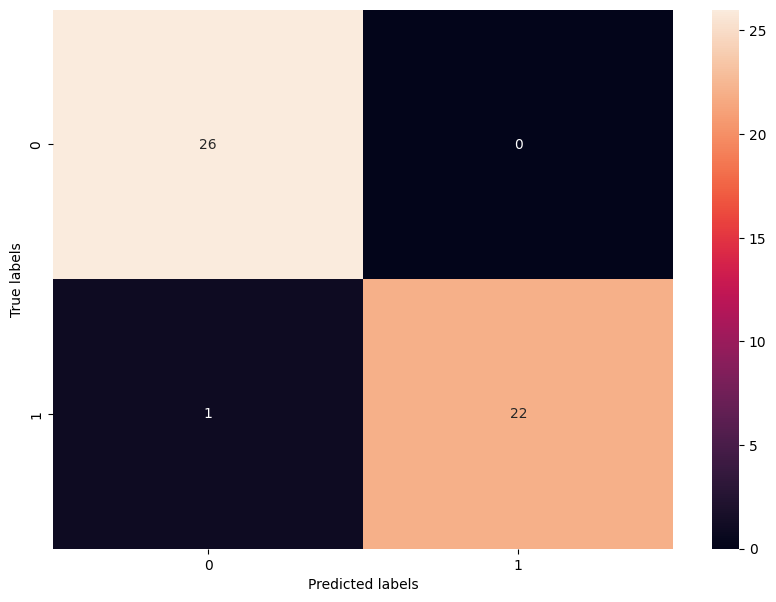

In [ ]:
# Matriz de confusão


# Criar a matriz de confusão
cm = confusion_matrix(y_test, y_pred)

# Plotar a matriz de confusão
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()